Epoch 1/10


C:\Users\Anish\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.3087 - loss: 1.3223 - val_accuracy: 0.5979 - val_loss: 0.8742
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.6335 - loss: 0.8591 - val_accuracy: 0.7629 - val_loss: 0.6077
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.8347 - loss: 0.4791 - val_accuracy: 0.9381 - val_loss: 0.2541
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.8614 - loss: 0.4171 - val_accuracy: 0.8866 - val_loss: 0.3605
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9444 - loss: 0.1771 - val_accuracy: 0.9381 - val_loss: 0.2222
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9844 - loss: 0.0836 - val_accuracy: 0.9588 - val_loss: 0.1860
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9944 - loss: 0.0438 - val_accuracy: 0.9381 - val_loss: 0.1580
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9852 - loss: 0.0533 - val_accuracy: 0.9381 - val_

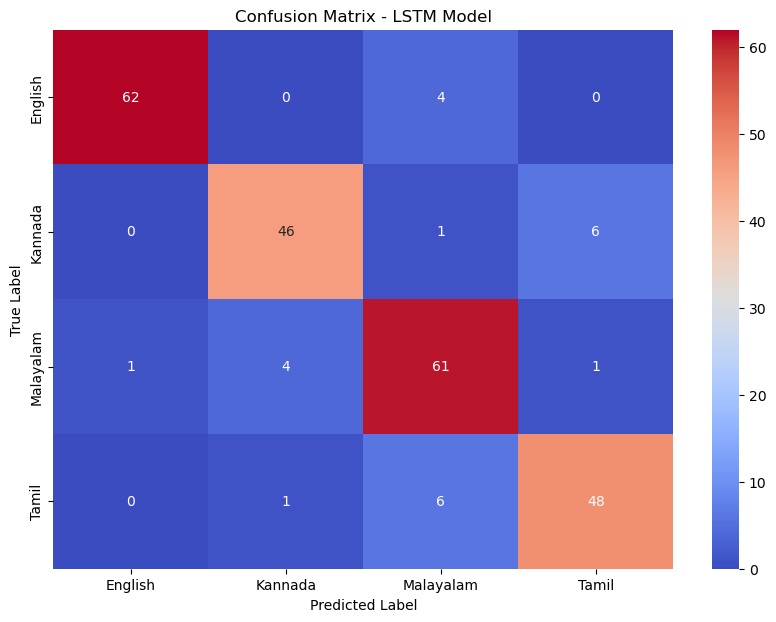

Total Errors: 24
Error Distribution:
English: 4 errors
Kannada: 7 errors
Malayalam: 6 errors
Tamil: 7 errors


In [6]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_excel(r"C:\Users\Anish\OneDrive\Desktop\Language_Detection(4).xlsx", engine='openpyxl')


def clean_text(text):
    text = re.sub(r'[\([{})\]!@#$,"%^*?:;~0-9]', ' ', text.lower())  
    text = re.sub(r'http\S+\s*', ' ', text)  
    text = re.sub(r'RT|cc', ' ', text)  
    text = re.sub(r'#\S+', '', text)  
    text = re.sub(r'@\S+', ' ', text)  
    text = re.sub(r'\s+', ' ', text)  
    return text

df['Cleaned_Text'] = df['Text'].apply(clean_text) 


X = df['Cleaned_Text']
y = df['Language']


encoder = LabelEncoder()
y = encoder.fit_transform(y)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Cleaned_Text'])
sequences = tokenizer.texts_to_sequences(df['Cleaned_Text'])
X = pad_sequences(sequences, maxlen=100)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=100))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(y)), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)


loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


print(f'Accuracy: {accuracy_score(y_test, y_pred_classes)}')
print(f'Precision: {precision_score(y_test, y_pred_classes, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred_classes, average="weighted")}')
print(f'F1 Score: {f1_score(y_test, y_pred_classes, average="weighted")}')
print(f'Classification Report:\n{classification_report(y_test, y_pred_classes)}')


conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix - LSTM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


errors = (y_test != y_pred_classes)
total_errors = np.sum(errors)
error_distribution = np.bincount(y_test[errors])
error_classes = encoder.inverse_transform(np.unique(y_test[errors]))

print(f"Total Errors: {total_errors}")
print("Error Distribution:")
for i, cls in enumerate(error_classes):
    print(f"{cls}: {error_distribution[i]} errors")


def predict_language(text):
    text_cleaned = clean_text(text)
    sequence = tokenizer.texts_to_sequences([text_cleaned])
    padded_sequence = pad_sequences(sequence, maxlen=100)
    prediction = model.predict(padded_sequence)
    predicted_label = np.argmax(prediction, axis=1)
    predicted_language = encoder.inverse_transform(predicted_label)
    return predicted_language[0]



In [8]:
model.save("dravidian_language_detection_model.keras")

In [26]:
test_text = "என்னை மன்னிக்கவும்."
predicted_language = predict_language(test_text)
print(f"The predicted language for '{test_text}' is {predicted_language}")
loaded_model = load_model("dravidian_language_detection_model.keras")
predicted_language_loaded = predict_language(test_text)
print(f"{predicted_language_loaded}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
The predicted language for 'என்னை மன்னிக்கவும்.' is Tamil
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tamil


In [24]:
test_text = "நான் கேட்கிறேன், பின்னர் நான் சொல்கிறேன்."
predicted_language = predict_language(test_text)
print(f"The predicted language for '{test_text}' is {predicted_language}")
loaded_model = load_model("dravidian_language_detection_model.keras")
predicted_language_loaded = predict_language(test_text)
print(f"{predicted_language_loaded}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
The predicted language for 'நான் கேட்கிறேன், பின்னர் நான் சொல்கிறேன்.' is Tamil
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Tamil


In [39]:
test_text = "I enjoy listening to music "
predicted_language = predict_language(test_text)
print(f"The predicted language for '{test_text}' is {predicted_language}")
loaded_model = load_model("dravidian_language_detection_model.keras")
predicted_language_loaded = predict_language(test_text)
print(f"{predicted_language_loaded}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
The predicted language for 'I enjoy listening to music ' is English
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
English


C:\Users\Anish\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
test_text = "വിക്കിപീഡിയയിൽ പ്രശ്നങ്ങളൊന്നും ഇല്ലെന്നല്ല."
predicted_language = predict_language(test_text)
print(f"The predicted language for '{test_text}' is {predicted_language}")
loaded_model = load_model("dravidian_language_detection_model.keras")
predicted_language_loaded = predict_language(test_text)
print(f"{predicted_language_loaded}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
The predicted language for 'വിക്കിപീഡിയയിൽ പ്രശ്നങ്ങളൊന്നും ഇല്ലെന്നല്ല.' is Malayalam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Malayalam


In [34]:
test_text = "ಹೇಗೆ ನಡೆಯುತ್ತಿದೆ?"
predicted_language = predict_language(test_text)
print(f"The predicted language for '{test_text}' is {predicted_language}")
loaded_model = load_model("dravidian_language_detection_model.keras")
predicted_language_loaded = predict_language(test_text)
print(f"{predicted_language_loaded}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The predicted language for 'ಹೇಗೆ ನಡೆಯುತ್ತಿದೆ?' is Kannada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Kannada


In [36]:
test_text = "ಮತ್ತು ನೀವು ಓಹ್ ಹಾಗೆ ಅದನ್ನು ವಿವರಿಸುವ ಅದನ್ನು ವಿವರಿಸುತ್ತದೆ."
predicted_language = predict_language(test_text)
print(f"The predicted language for '{test_text}' is {predicted_language}")
loaded_model = load_model("dravidian_language_detection_model.keras")
predicted_language_loaded = predict_language(test_text)
print(f"{predicted_language_loaded}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
The predicted language for 'ಮತ್ತು ನೀವು ಓಹ್ ಹಾಗೆ ಅದನ್ನು ವಿವರಿಸುವ ಅದನ್ನು ವಿವರಿಸುತ್ತದೆ.' is Kannada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Kannada
